In this notebook I will discuss how we can use logistic regression for fraud prediction. We will see that the dataset is highly imbalanced, and discuss how this can be dealt with. Please skip the first block, where I only define some helper functions.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
import itertools
import plot_confusion as pc

Problem Analysis
===
We load and prepare the data:

In [2]:
df = pd.read_csv("Data/creditcard.csv")
print(df.head(3))
y = np.array(df.Class.tolist())     #classes: 1..fraud, 0..no fraud
df = df.drop('Class', 1)
df = df.drop('Time', 1)     # optional
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))    #optionally rescale non-normalized column
X = np.array(df.as_matrix())   # features

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]


A class of 0 means that the transaction was in order, and a class of 1 means that the transaction was fraudulent. From personal experience we expect frauds to make up only a tiny fraction of all transactions. Indeed, in this dataset, for every fraud there are almost 600 non-fraudulent transactions:

In [3]:
print("Fraction of frauds: {:.5f}".format(np.sum(y)/len(y)))

Fraction of frauds: 0.00173


**Since the classes are highly imbalanced, we need to consider an appropriate measure for the quality of a fraud detection method.** If we would naively count the fraction of classes we got right (i.e. correctly predicted 0 or 1), already the simple model that *always* predicts 0 (non-fraud) would achieve an "accuracy" of 99.827%, since only frauds are not recognized correctly, and they are obviously rare. However, such a model is nonsense, since it cannot tell us whether a given transaction is a fraud or not. And *the extremely high accuracy is misleading*, and does not tell us anything about the actual quality of the prediction. Hence, we need a more sophisticated approach to evaluate a prediction. Let us illustrate this with a simple Logistic Regression (without parameter tuning, ..., yet).

We split the data into a training set (X, y) and a validation set (X_val, y_val):

In [4]:
X, X_val, y, y_val = train_test_split(X, y, test_size = 0.2)

The following grid search will be done using the (training) data.

We split the data into a training set and a test set. Note that the split needs to be stratified, since the classes are so imbalanced.

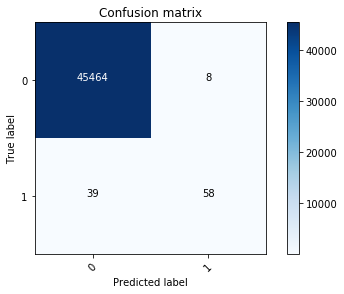

Precision =     0.879
Recall (TPR) =  0.598
Fallout (FPR) = 1.759e-04


In [5]:
lrn = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lrn.fit(X_train, y_train)
y_pred = lrn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
if lrn.classes_[0] == 1:
    #make sure the ordering of the classes is correct
    cm = np.array([[cm[1,1], cm[1,0]], [cm[0,1], cm[0,0]]])

pc.plot_confusion_matrix(cm, ['0', '1'], )
pr, tpr, fpr = pc.show_data(cm, print_res = 1);

We have split the data into a training and a testing set at a ratio of 4:1, trained a Logistic Regression on the training set, and predicted the outcome on the testing set. The result of this prediction is depicted in the confusion matrix. We can see that almost all non-fraudulent transactions are also recognized as such. About 2/3 of all frauds are detected, but quite many are not recognized. The confusion matrix is a convenient way of illustrating the behavior of a classifier.

- The **Precision** denotes the probability that a transaction that is classified as fraud is truly a fraud.
- The **Recall** (aka. True Positive Rate) is the probability that a true fraud is recognized by the classifier.
- The **Fallout** (aka. False Positive Rate) is the probability that a non-fraud is wrongly classified as a fraud.

These numbers provide a more tangible characterization of a classifier. When tuning the parameters for a classifier, we need to ask ourselves what we expect of a "good" classifier.

- The Precision should be large (close to 1). A precision close to 0 means that a fraud alert will turn out as a mistake in the majority of the cases. This can be annoying for customers.
- The Recall should be close to 1. We want to detect frauds with a high probability. A recall of ~60% like for the classifier above is certainly not good enough - many frauds will go undetected. We definitly aim for something higher, 80% would be quite good! (Note that since frauds are often non-singular events on an account, it can be good enough to detect at least one out of two frauds - with a Recall of 80% this means that the probability that two consecutive frauds go undetected is as low as 4% already!)
- The Fallout should be very low. Customers would not want to receive a fraud alert every week. I speculate that a Fallout less than 0.1% would be adequate - for an average daily number of 3 transactions this would result in 1 wrong alert per year. Here we will actually aim for the even better fallout <3e-4.

Parameter Tuning
===
The parameters I want to optimize are *C* in the logistic regression, the class weight, and the probability threshold: The logistic regression returns *probabilities* for the predicted classes, and the prediction is usually based on whether a probability is above a certain threshold or not. By changing the threshold, we can make our model more sensitive (but also increase wrong detections), or less strict (and miss more frauds).

A canonical approach for our problem would be the ROC-curve, which plots the Recall vs. the Fallout for varying thresholds. Recall and Fallout are precisely the quantities we are interested of. It will not tell us which threshold is suitable, but it will help us find the optimal *C*. 

We will determine the ROC-curve from repeating a stratified splitting, and taking the mean, in order to eliminate noise. The logistic regression can take imbalanced classes into account, using the option *class_weight*. The parameter *r* gives a weight to the underrepresented class 1: *r=1* gives class 1 a weight inversely proportional to its occurence, which is actually recommended. The bigger *r* is chosen, the less weight is given to class 1 (see the specification in *dic_weight* below).

The following function creates the data for the ROC-curve through repeating StratifiedKFold:

In [6]:
def ROC(X, y, c, r):
#makes cross_validation for given parameters c,r. Returns FPR, TPR (averaged)
    dic_weight = {1:len(y)/(r*np.sum(y)), 0:len(y)/(len(y)-r*np.sum(y))} #specify class weights
    lrn = LogisticRegression(penalty = 'l2', C = c, class_weight = dic_weight)
    
    N_iter = 300    #repeat how often (taking the mean)
    mean_tpr = 0.0
    mean_thresh = 0.0
    mean_fpr = np.linspace(0, 1, 50000)
    mean_auc = 0   
    
    for it in range(N_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        lrn.fit(X_train, y_train)
        y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        thresholds[0] = 1
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_thresh += np.interp(mean_fpr, fpr, thresholds)
        mean_tpr[0] = 0.0
        mean_auc += roc_auc_score(y_test, y_prob)

    mean_tpr /= N_iter
    mean_thresh /= N_iter
    mean_tpr[-1] = 1.0

    return mean_fpr, mean_tpr, mean_auc/N_iter, mean_thresh

The following plots the ROC-curve for different parameters:

In [7]:
def plot_roc(X,y, list_par_1, par_1 = 'C', par_2 = 1):

    f = plt.figure(figsize = (12,8));
    for p in list_par_1:
        if par_1 == 'C':
            c = p
            r = par_2
        else:
            r = p
            c = par_2
        list_FP, list_TP, AUC, mean_thresh = ROC(X, y, c, r)      
        plt.plot(list_FP, list_TP, label = 'C = {}, r = {}, TPR(3e-4) = {:.4f}'.format(c,r,list_TP[10]));
        del list_FP, list_TP
    plt.legend(title = 'values', loc='lower right')
    plt.xlim(0, 0.001)   #we are only interested in small values of FPR
    plt.ylim(0.5, 0.9)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC detail')
    plt.axvline(3e-4, color='b', linestyle='dashed', linewidth=2)
    plt.show()
    plt.close()


We will now perform a grid search, in order to find quasi-optimal parameters *C* and *r*. Say that we want a Fallout < 3e-4. Our goal is to maximize TPR for FPR = 3e-4 (see the dotted vertical line).

*Note that the grid search here is likely to yield different results from a search maximizing the ROC AUC: The initially (for very small FPR) steepest ROC could (and indeed does) not have the largest AUC. Maximizing the TPR for a fixed FPR seems the more promising strategy here, since we care about very small FPR.*

Let us first look at the influence of the class weight parameter *r* (since only *r* = 1 correctly represents the class weights, we somehow expect to find *r* = 1 confirmed):

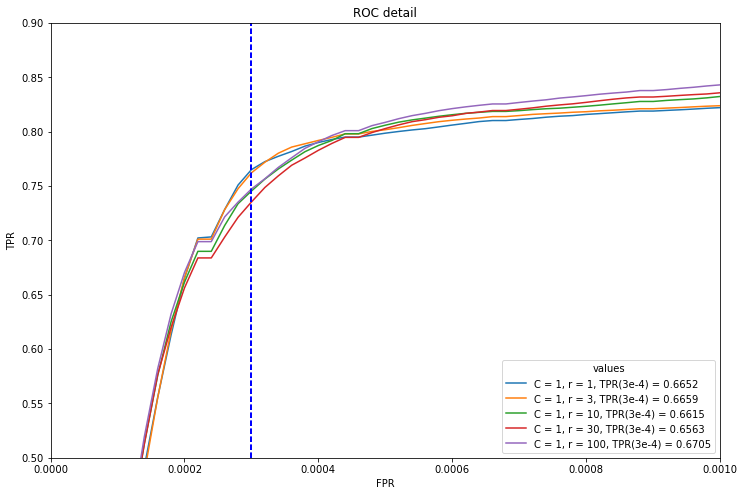

In [8]:
plot_roc(X,y, [1, 3, 10, 30, 100], 'r', 1)

From the plots we find that for a Fallout less than 4e-4 and *C = 1* the model works best for small values of *r*. Since *r* = 1 is the natural choice, we will fix this value for now.

We proceed now with *r* = 1, and search for a good choice of *C*:

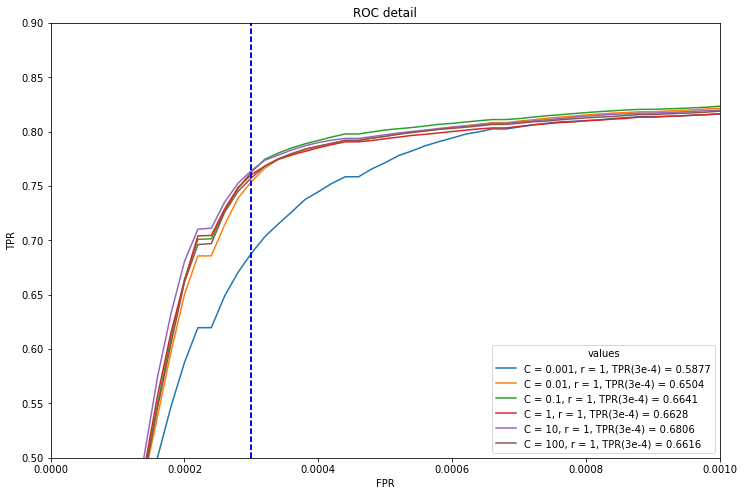

In [9]:
plot_roc(X,y, [0.001, 0.01, 0.1, 1, 10, 100], 'C', 1) 

Especially the very small *C* = 0.001 stands out with significantly poorer performance. For all larger values the model performs similarly well, and we pick *C* = 1 for our final model.


Determining the Threshold
===

As we will see soon, it is a probability threshold very close to 1 yields the desired result. I will now repeat the stratified splitting with the final parameters, and plot TPR and FPR as functions of the threshold, so that we can choose an appropriate threshold.

In [10]:
N = np.arange(10,80,2)     # will define threshold
cm = {}     #will store the confusion matrix for different thresholds
for n in N:
    cm[n] = 0.0
lrn = LogisticRegression(penalty = 'l2', C = 1, class_weight = 'balanced')   #'balanced' corresponds to the case r=1

N_iter = 300   #repeat how often (taking the mean)
for it in range(N_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    lrn.fit(X_train, y_train)
    y_prob = lrn.predict_proba(X_test)[:,lrn.classes_[1]]
    for n in N:
        thresh = 1 - np.power(10.,-(n/10))  #we want thresholds very close to 1
        # generate the prediction from the probabilities y_prob:
        y_pred = np.zeros(len(y_prob))
        for j in range(len(y_prob)):
            if y_prob[j] > thresh:
                y_pred[j] = 1

        B = confusion_matrix(y_test, y_pred)
        #if the classes are mixed up, remedy that:
        if lrn.classes_[0] == 1:
            B = np.array([[B[1,1], B[1,0]], [B[0,1], B[0,0]]])
        cm[n]+=B
#finally, normalize the confusion matrices:
for n in N:
    cm[n] = cm[n]//N_iter

We have now averaged confusion matrices for different thresholds, stored in *cm*. We extract TPR and FPR from the matrices, and plot them:

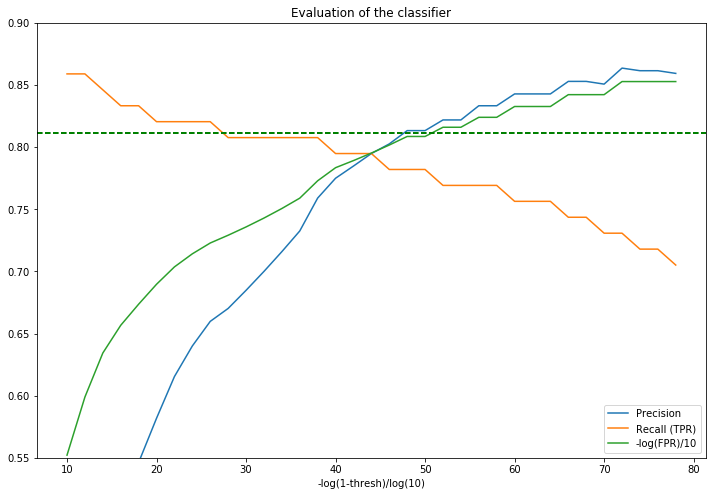

In [11]:
PR = []      #precision
TPR = []
FPR = []
THRESH = N
for n in N:
    pr, tpr, fpr = pc.show_data(cm[n])
    PR.append(pr)
    TPR.append(tpr)
    FPR.append(-np.log(fpr)/10)

g  = plt.figure(figsize = (12,8))   
plt.plot(THRESH, PR, label = 'Precision')
plt.plot(THRESH, TPR, label = 'Recall (TPR)')
plt.plot(THRESH, FPR, label = '-log(FPR)/10')
plt.axhline(-np.log(3e-4)/10, linestyle='dashed', color = 'green', linewidth=2)
plt.title('Evaluation of the classifier')
plt.legend( loc='lower right')
plt.xlabel('-log(1-thresh)/log(10)')
plt.ylim(0.55,0.9)
plt.show()

If we want a Fallout < 3e-4 we are only interested in data right of the intersection of the dotted line and the FPR-curve. We compute Recall, Fallout and Precision for the corresponding threshold:

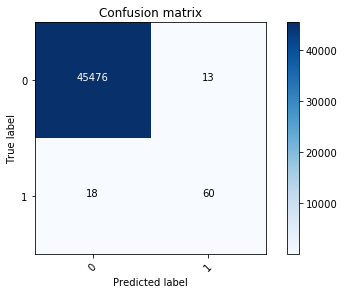

Precision =     0.822
Recall (TPR) =  0.769
Fallout (FPR) = 2.858e-04


In [12]:
i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
pc.plot_confusion_matrix(A, ['0', '1'])
pc.show_data(A, print_res = 1);

To some extent we can use this model for different thresholds, or FPR, respectively. Only for FPR > 4e-4 the above cross-validation would need to be redone. Let us check what happens when we relax the FPR-requirement:

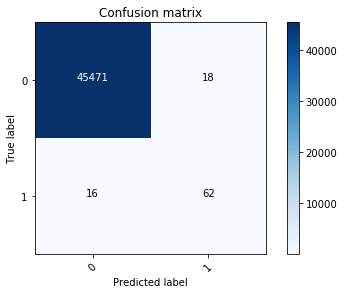

Precision =     0.775
Recall (TPR) =  0.795
Fallout (FPR) = 3.957e-04


In [13]:
i = 0
while FPR[i] < -np.log(4e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
pc.plot_confusion_matrix(A, ['0', '1'])
pc.show_data(A, print_res = 1);

This is not really an improvement - in particular the Recall did not improve significantly, only the Fallout got worse. This is not desirable. Let us also look at a smaller FPR of 2e-4:

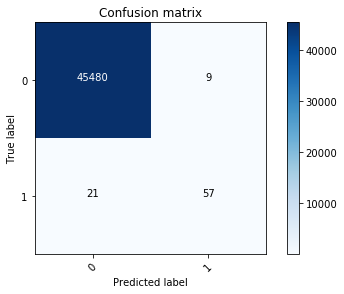

Precision =     0.864
Recall (TPR) =  0.731
Fallout (FPR) = 1.979e-04


In [14]:
i = 0
while FPR[i] < -np.log(2e-4)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
pc.plot_confusion_matrix(A, ['0', '1'])
pc.show_data(A, print_res = 1);

In the end I think that that a fallout between 2e-4 and 3e-4 is reasonabe. The expected recall then lies between 75% and 80%. The final choice might depend on practical considerations, based on data not available here (e.g. what are the costs for the bank of a false alert vs. a not detected fraud). Similarly to the approach taken here, one could also fix a Recall and then minimize the Fallout. However, the above analysis indicates that the ROC-curve flattens out significantly for FPR > 4e-4, and a Recall over 80% is extremely hard to achieve - and then only in combination with a drastic increase of the Fallout, for example:

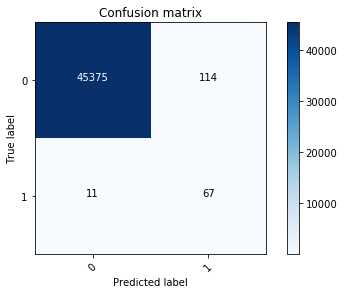

Precision =     0.370
Recall (TPR) =  0.859
Fallout (FPR) = 2.506e-03


In [15]:
i = 0
while FPR[i] < -np.log(3e-3)/10:
    i+=1
A = cm[THRESH[i]].astype(int)
pc.plot_confusion_matrix(A, ['0', '1'])
pc.show_data(A, print_res = 1);

Validation and Conclusion
===
On the training data we have found that for a Fallout of 0.03% we can obtain a Recall of roughly 80%. Any significant improvement of the Recall comes with very high cost for the Fallout. Similarly, any substantial improvement of the Fallout will drastically reduce the Fallout.

We finally test our model on the still 'unspoiled' validation data set:

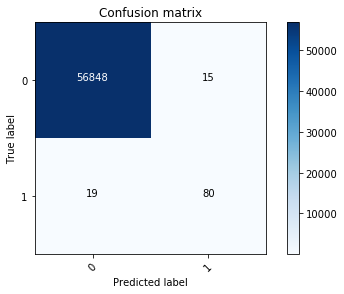

Precision =     0.842
Recall (TPR) =  0.808
Fallout (FPR) = 2.638e-04


In [16]:
lrn.fit(X, y)
y_pred = lrn.predict_proba(X_val)[:,lrn.classes_[1]]
i = 0
while FPR[i] < -np.log(3e-4)/10:
    i+=1
thresh = 1 - 10.**(-THRESH[i]/10)
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0
cm = confusion_matrix(y_val, y_pred)

pc.plot_confusion_matrix(cm, ['0', '1'])
pc.show_data(cm, print_res = 1);

The model performs similarly (actually slightly better, but not significantly) as we expect it to from the cross-validation.

In my next notebook I will compare these results with others obtained with XGBoost.